# CIFAR-10 Linear Model

La première étape intermédiaire de notre projet est d'utiliser les algorithmes ci-dessous sur le célébre dataset CIFAR-10.

Les algorithmes à étudier :

**Modèles précédents**
- Modèle Linéaire
- Perceptron Multicouches

**Nouveaux modèles**
- ConvNet(s)
- ResNets / HighwayNets 
- RNN(s)

Pour chacun des algorithmes cités, il faut :
1. L'influence de tous les hyperparamètres des modèles
    - Structure
    - Fonctions d'activations
    - etc.
2. Les paramètres des algorithmes d'apprentissages
    - Learning Rate
    - Momentum
    - etc.
    
----

### Méthodologie
1. Créer un modèle classique.
2. Entraîner le modèle pendant 500 epochs.
3. Examiner sa courbe TensorBoard et son accuracy.
4. Augmenter un des hyperparamètre.
5. Réduire ce même hyperparamètre.
6. Dire l'influence de cette hyperparamètre sur la courbe et sur le modèle de manière générale.
7. Recommencer à partir de l'étape 3 pour tout les hyperparamètres possibles.

#### Hyperparamètres
- Batch size
- Learning rate
- Momentum
- Structure
- Fonction d'activation
- Initialization de kernel
- Regularizers (Dropout, L1 Norm, L2 Norm)

#### Qui s'occupe de quoi ?
- Perceptron (Mamadian)
- MLP (Réda M.)
- ConvNet (Reda B.)

In [1]:
import os
import numpy as np
from numpy.random import seed
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Conv2D, BatchNormalization, Input, Average, MaxPool2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.activations import relu, softmax, tanh
from tensorflow.keras.initializers import he_normal, glorot_uniform
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.random import set_seed
from tensorflow import keras

In [2]:
print("Version de TensorFlow :", tf.__version__)
print("Nom du GPU :", tf.test.gpu_device_name())

tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(False)

Version de TensorFlow : 2.7.0
Nom du GPU :Metal device set to: Apple M1
 /device:GPU:0


2022-01-09 01:09:30.842654: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-09 01:09:30.842750: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Importation du dataset

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
NUM_CLASSES = 10
IMG_SIZE = x_train[0].shape

In [5]:
x_train = x_train.astype('float32') / 256
x_test = x_test.astype('float32') / 256

y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
y_test = to_categorical(y_test, num_classes=NUM_CLASSES)

In [6]:
LOG_DIR = os.path.join("logs")

## Fixer les seeds

In [7]:
set_seed(42) # TensorFlow
seed(42) # NumPy

# Modèle ResNets

In [8]:
OPTIMIZER = SGD
BATCH_SIZE = 512
EPOCHS = 200
SHUFFLE = True
LEARNING_RATE = 0.01
MOMENTUM = 0.1
FILTERS = 32
NUM_CLASSES = 10

In [9]:
def ResNet(num_layer, filters):
    input_layer = Input(shape=(32, 32, 3))
    hidden_layers = input_layer
    
    for n in range(num_layer):
        prev_layer = hidden_layers
        hidden_layers = Conv2D(filters, (3, 3), padding='same', activation=relu,
                                            kernel_initializer=he_normal)(hidden_layers)
        #hidden_layers = Dropout(0.2)(hidden_layers)
        if n > 0:
            hidden_layers = keras.layers.Add()([hidden_layers, prev_layer]) / 2.0
        else:
            hidden_layers = keras.layers.Add()([hidden_layers, Dense(32)(prev_layer)]) / 2.0
    
    hidden_layers = Flatten()(hidden_layers)   
    output_layer = Dense(NUM_CLASSES, activation=softmax,
                        kernel_regularizer=l2(0.01),
                        bias_regularizer=l2(0.01))(hidden_layers)
    return Model(input_layer, output_layer)


### ResNet 10,50

In [13]:
num_blocks = [10,50]
for b in num_blocks:
    resnet= ResNet(b,FILTERS)
    resnet.compile(loss=categorical_crossentropy,
                  optimizer=SGD(LEARNING_RATE,MOMENTUM),
                  metrics= categorical_accuracy)
    RESNET_LOG = os.path.join(LOG_DIR, "resnet",
                        f"resnet_ep_{EPOCHS}_bs_{BATCH_SIZE}_opt_SGD_lr_{LEARNING_RATE}_mom_{MOMENTUM}_filters_{FILTERS}_blocks_{b*2}_skipconnection_everyblocks")
    resnet.fit(x_train,y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(x_test, y_test),
              shuffle=SHUFFLE,
              callbacks=[tf.keras.callbacks.TensorBoard(RESNET_LOG, histogram_freq=1)]
              )

Epoch 1/200


2022-01-07 18:39:24.220977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 2.3492 - categorical_accuracy: 0.2049

2022-01-07 18:39:51.176190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 30s 298ms/step - loss: 2.3492 - categorical_accuracy: 0.2049 - val_loss: 2.2074 - val_categorical_accuracy: 0.3121
Epoch 2/200
98/98 [==============================] - 29s 292ms/step - loss: 2.1505 - categorical_accuracy: 0.3161 - val_loss: 2.0806 - val_categorical_accuracy: 0.3349
Epoch 3/200
98/98 [==============================] - 29s 293ms/step - loss: 1.9859 - categorical_accuracy: 0.3681 - val_loss: 2.0426 - val_categorical_accuracy: 0.3408
Epoch 4/200
98/98 [==============================] - 29s 293ms/step - loss: 1.8855 - categorical_accuracy: 0.3988 - val_loss: 1.8048 - val_categorical_accuracy: 0.4172
Epoch 5/200
98/98 [==============================] - 29s 293ms/step - loss: 1.8280 - categorical_accuracy: 0.4164 - val_loss: 1.8032 - val_categorical_accuracy: 0.4240
Epoch 6/200
98/98 [==============================] - 29s 294ms/step - loss: 1.7755 - categorical_accuracy: 0.4310 - val_loss: 1.7537 - val_categorical_accuracy: 0.4337
Epoc

98/98 [==============================] - 34s 342ms/step - loss: 0.5289 - categorical_accuracy: 0.8775 - val_loss: 1.7088 - val_categorical_accuracy: 0.5996
Epoch 98/200
98/98 [==============================] - 34s 344ms/step - loss: 0.5302 - categorical_accuracy: 0.8753 - val_loss: 1.5907 - val_categorical_accuracy: 0.6173
Epoch 99/200
98/98 [==============================] - 34s 343ms/step - loss: 0.5127 - categorical_accuracy: 0.8854 - val_loss: 1.6763 - val_categorical_accuracy: 0.6201
Epoch 100/200
98/98 [==============================] - 34s 343ms/step - loss: 0.5194 - categorical_accuracy: 0.8852 - val_loss: 1.4809 - val_categorical_accuracy: 0.6361
Epoch 101/200
98/98 [==============================] - 34s 343ms/step - loss: 0.4929 - categorical_accuracy: 0.8942 - val_loss: 1.9164 - val_categorical_accuracy: 0.5945
Epoch 102/200
98/98 [==============================] - 34s 344ms/step - loss: 0.4948 - categorical_accuracy: 0.8972 - val_loss: 1.6460 - val_categorical_accuracy: 0.6

98/98 [==============================] - 33s 333ms/step - loss: 3.1913 - categorical_accuracy: 0.4461 - val_loss: 3.1206 - val_categorical_accuracy: 0.4543
Epoch 194/200
98/98 [==============================] - 32s 332ms/step - loss: 3.1077 - categorical_accuracy: 0.4497 - val_loss: 3.0711 - val_categorical_accuracy: 0.4468
Epoch 195/200
98/98 [==============================] - 32s 330ms/step - loss: 3.0229 - categorical_accuracy: 0.4566 - val_loss: 2.9724 - val_categorical_accuracy: 0.4647
Epoch 196/200
98/98 [==============================] - 32s 330ms/step - loss: 2.9364 - categorical_accuracy: 0.4646 - val_loss: 2.9015 - val_categorical_accuracy: 0.4616
Epoch 197/200
98/98 [==============================] - 32s 330ms/step - loss: 2.8549 - categorical_accuracy: 0.4720 - val_loss: 2.8017 - val_categorical_accuracy: 0.4765
Epoch 198/200
98/98 [==============================] - 2093s 22s/step - loss: 2.7893 - categorical_accuracy: 0.4734 - val_loss: 2.7330 - val_categorical_accuracy: 0

Resultat:

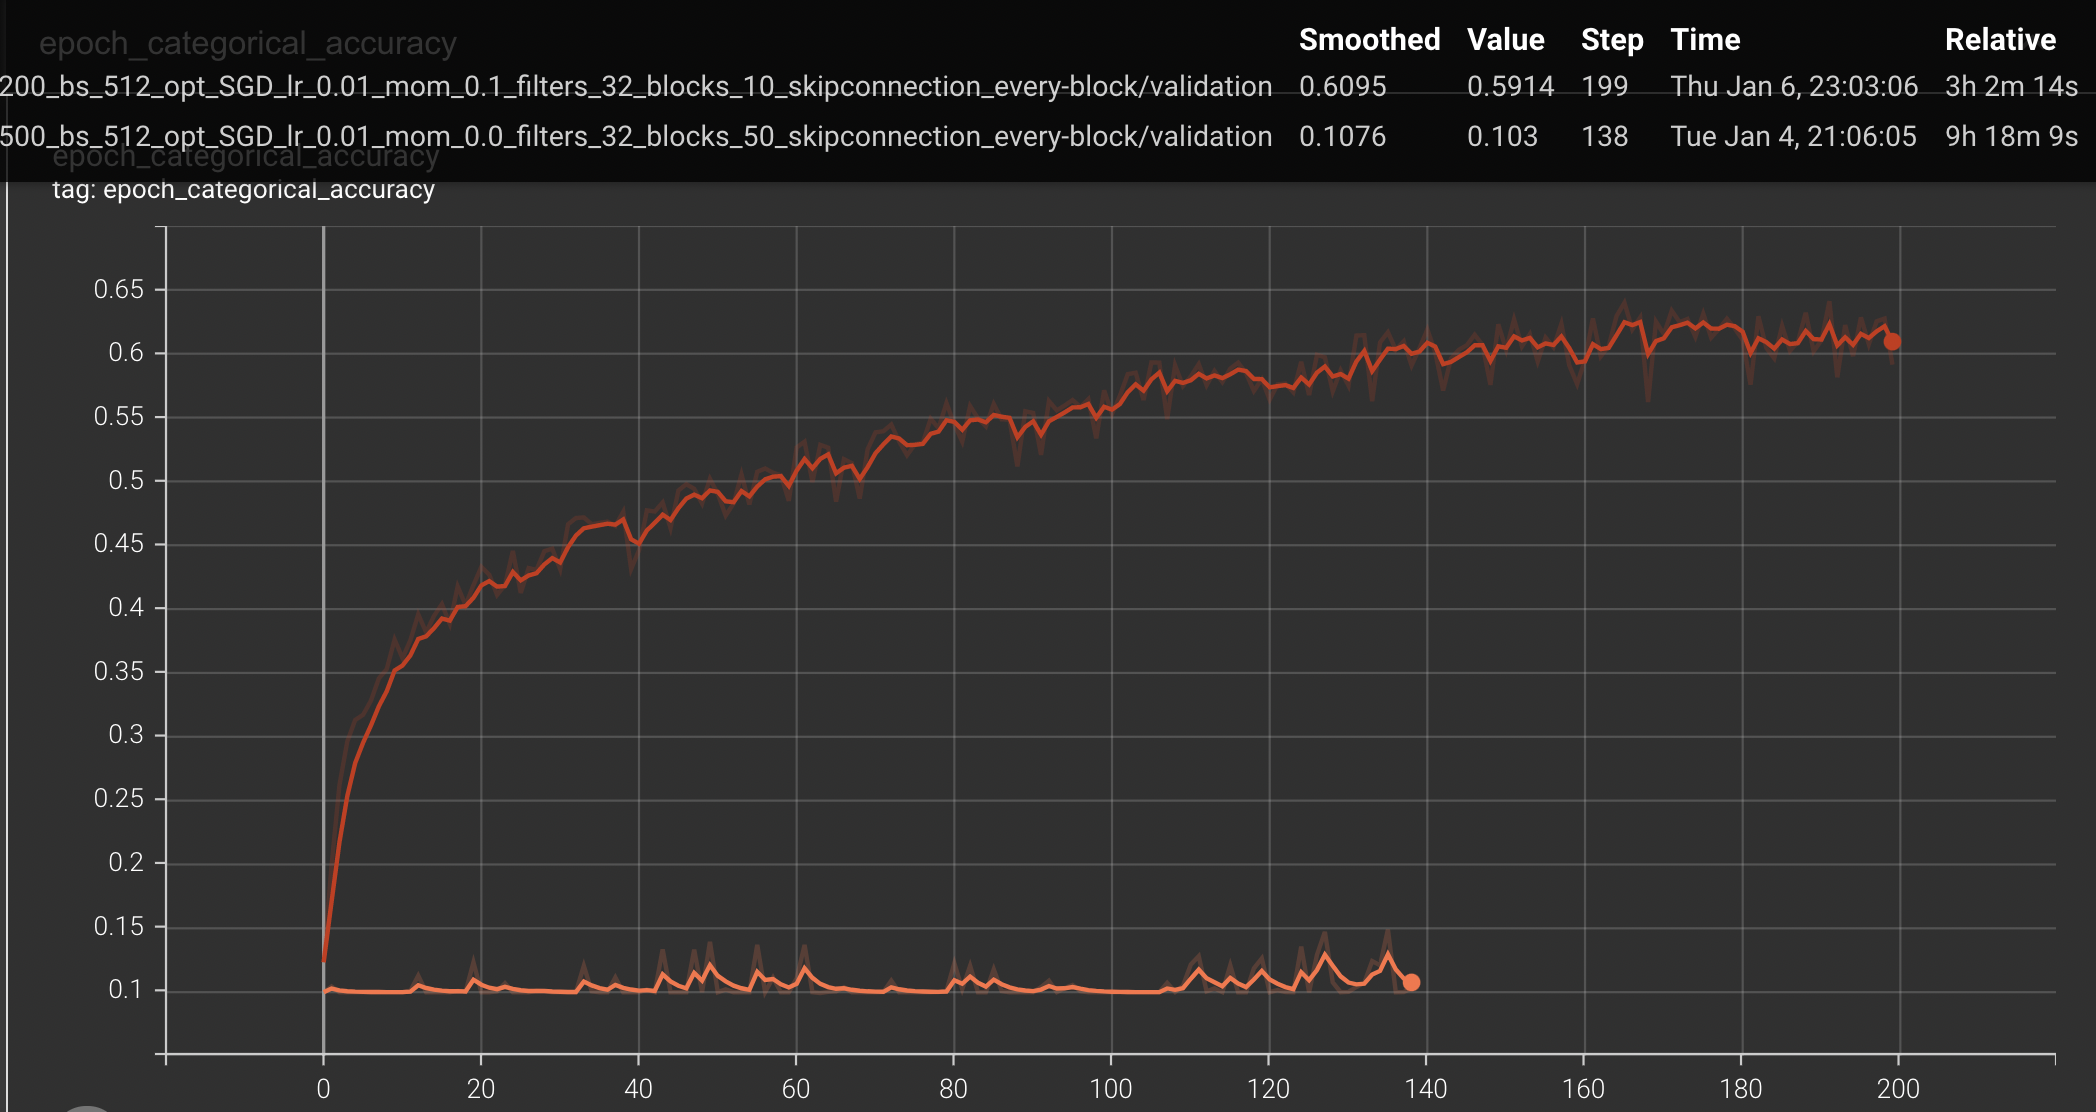

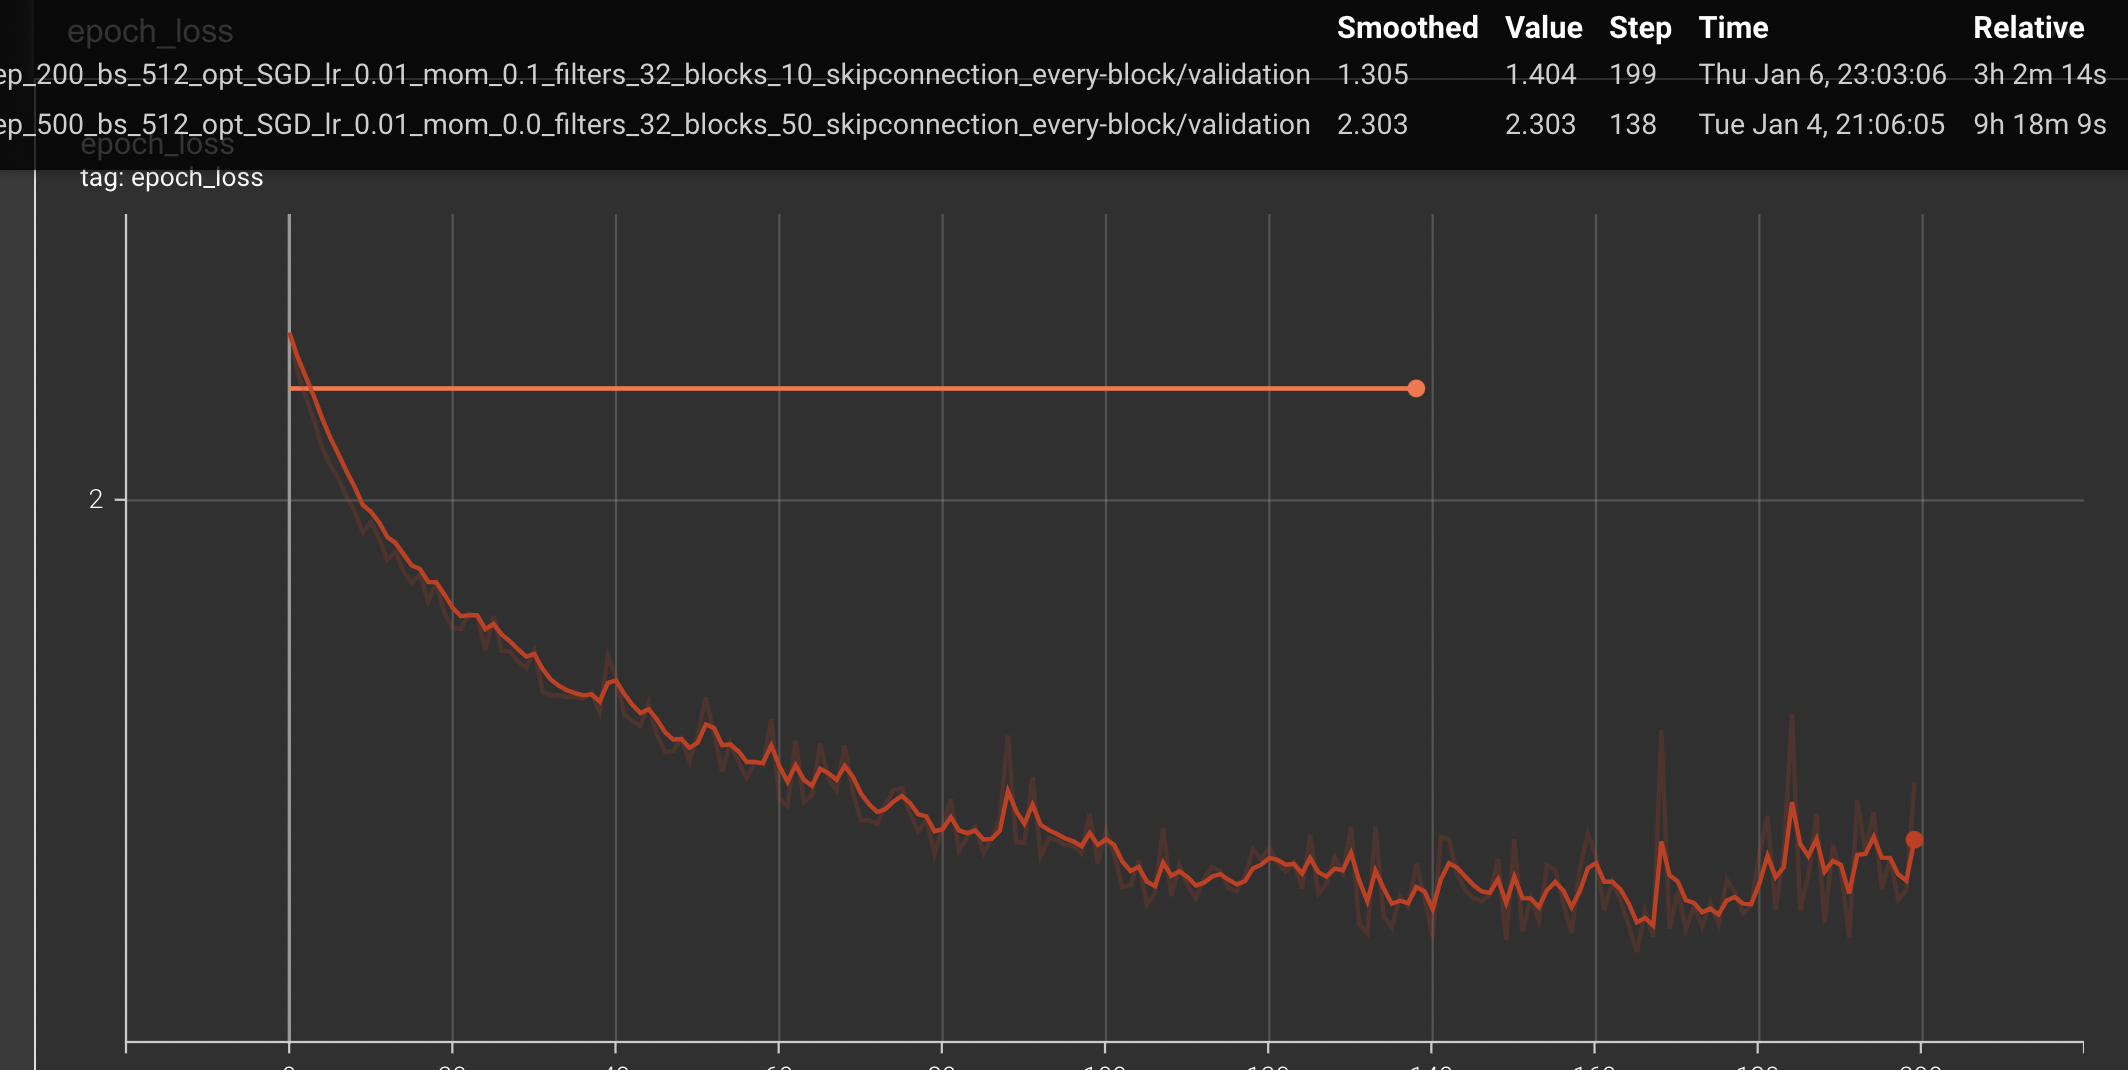

On peut voir qu'avec un resnet à 10 blocks(courbes rouge) et les hyperparametres choisi, on a de meilleurs resultat en moins de temps que le resnet à 50 blocks(orange). on voit que les resultats sont assez linéaire pour le resnet à 50 blocks (orange).

### Frequence des skipconnection

In [ ]:
def ResNet_skipconnection(num_layer, filters):
    input_layer = Input(shape=(32, 32, 3))
    hidden_layers = input_layer
    
    for n in range(num_layer):
        prev_layer = hidden_layers
        hidden_layers = Conv2D(filters, (3, 3), padding='same', activation=relu,
                                            kernel_initializer=he_normal)(hidden_layers)
        hidden_layers = Conv2D(filters, (3, 3), padding='same', activation=relu,
                                            kernel_initializer=he_normal)(hidden_layers)
        #hidden_layers = Dropout(0.2)(hidden_layers)
        if n > 0:
            hidden_layers = keras.layers.Add()([hidden_layers, prev_layer]) / 2.0
        else:
            hidden_layers = keras.layers.Add()([hidden_layers, Dense(32)(prev_layer)]) / 2.0
    
    hidden_layers = Flatten()(hidden_layers)   
    output_layer = Dense(NUM_CLASSES, activation=softmax,
                        kernel_regularizer=l2(0.01),
                        bias_regularizer=l2(0.01))(hidden_layers)
    return Model(input_layer, output_layer)


In [ ]:
num_blocks = [3]
for b in num_blocks:
    resnet= ResNet(b,FILTERS)
    resnet.compile(loss=categorical_crossentropy,
                  optimizer=SGD(LEARNING_RATE,MOMENTUM),
                  metrics= categorical_accuracy)
    RESNET_LOG = os.path.join(LOG_DIR, "resnet",
                        f"resnet_ep_{EPOCHS}_bs_{BATCH_SIZE}_opt_SGD_lr_{LEARNING_RATE}_mom_{MOMENTUM}_filters_{FILTERS}_blocks_{b*2}_skipconnection_every-2_blocks")
    resnet.fit(x_train,y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(x_test, y_test),
              shuffle=SHUFFLE,
              callbacks=[tf.keras.callbacks.TensorBoard(RESNET_LOG, histogram_freq=1)]
              )

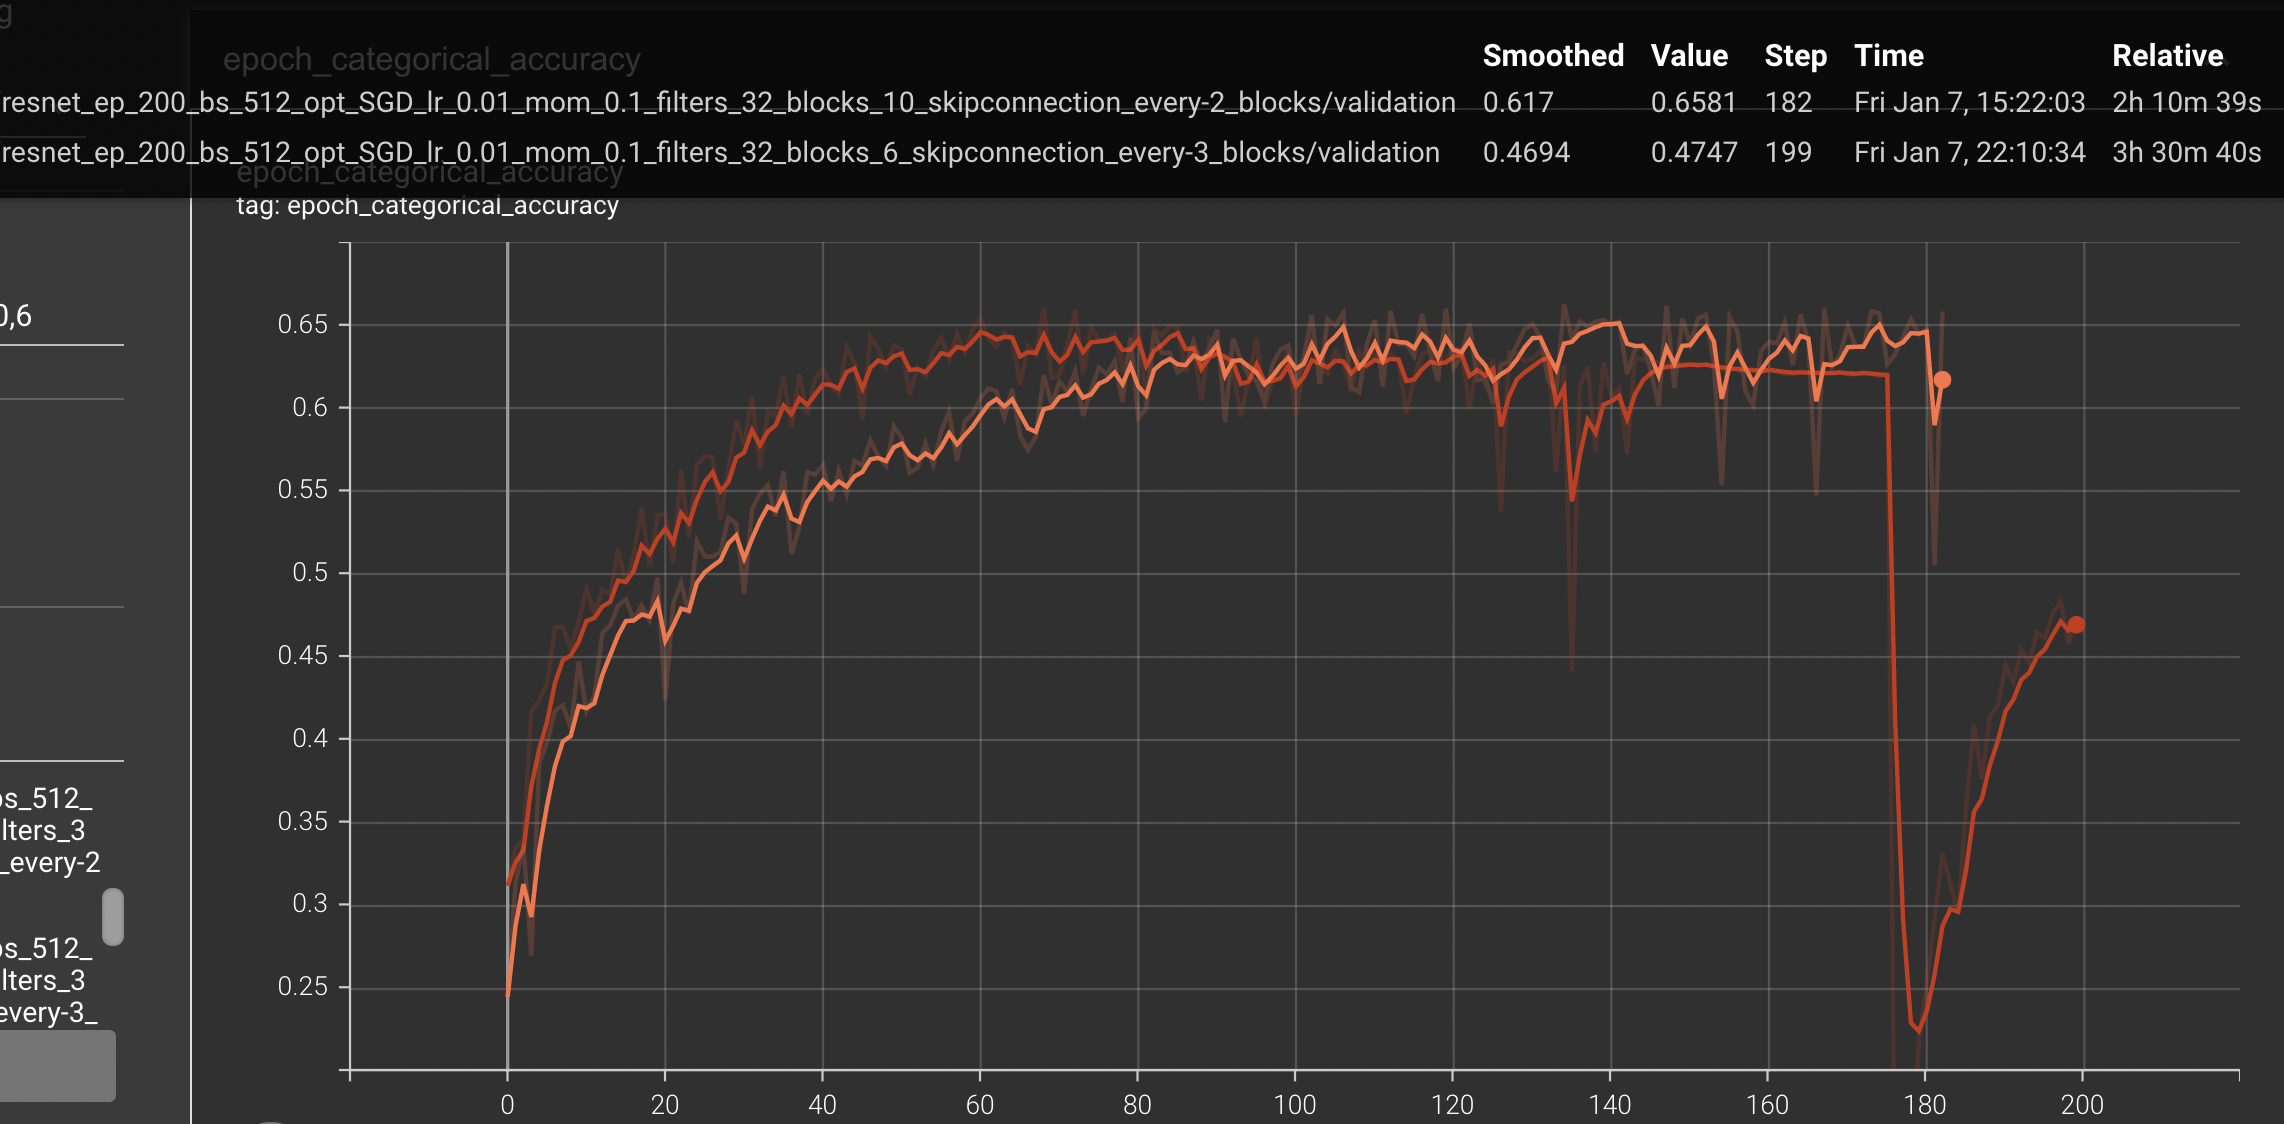

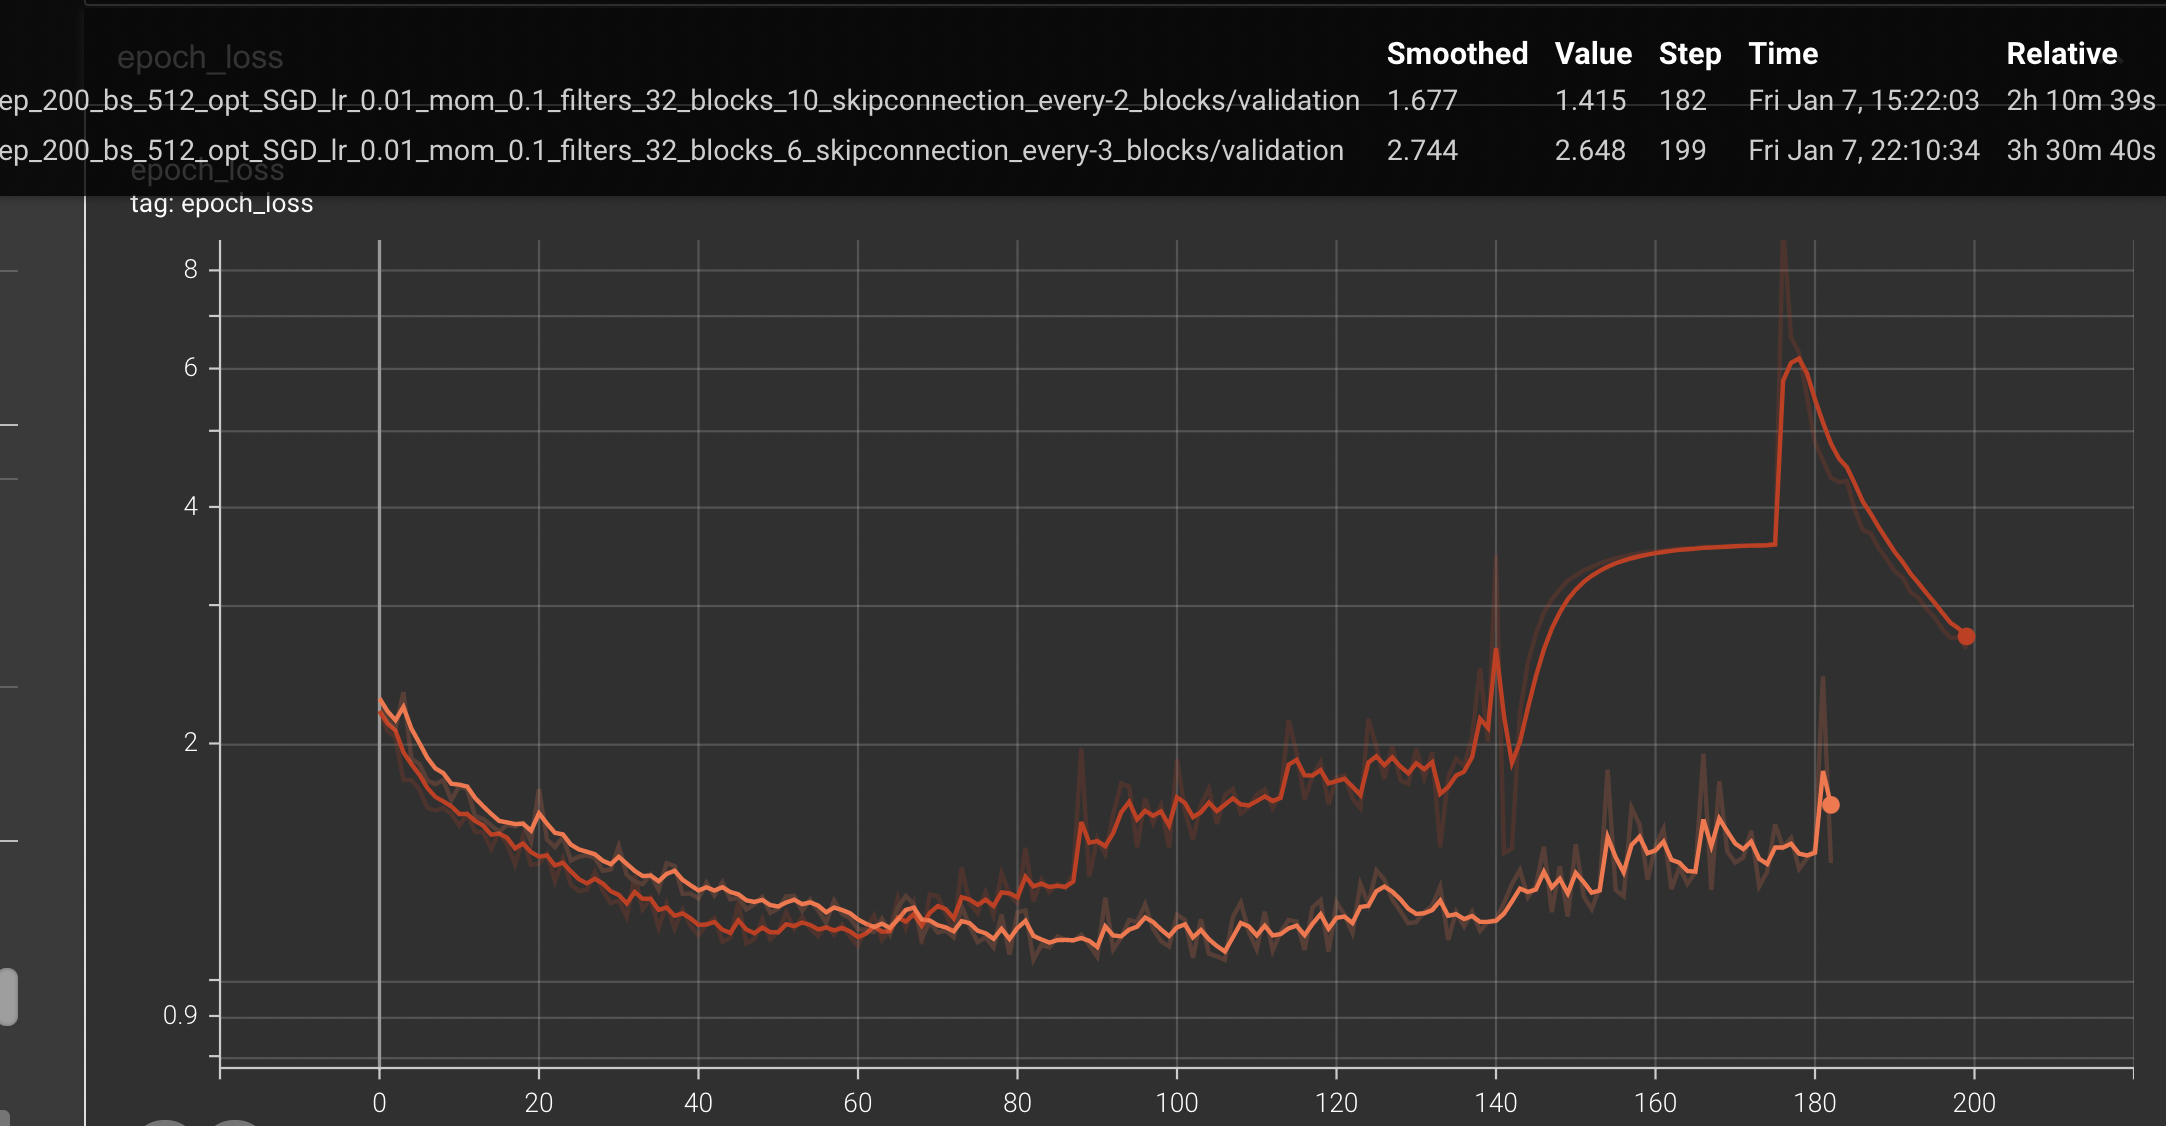

On voit que les deux modeles on une bonne croissance au début de l'entrainement mais on voit que le modele avec une skip connection tous les 3 blocks commence à sur-apprendre beaucoup plus tôt et plus fort. on voit que le modele avec une skip connection tous les 2 blocks va peut etre stagner par la suite.

### Resnet avec des couches Dense

In [11]:
def Resnet_dense(num_layer, filters):
    input_layer = Input(shape=(32, 32, 3))
    hidden_layers = input_layer
    
    for n in range(num_layer):
        prev_layer = hidden_layers
        hidden_layer = keras.layers.Dense(128, activation=tanh)(hidden_layer)
        hidden_layer = keras.layers.Dense(128, activation=tanh)(hidden_layer)
        
        #hidden_layers = Dropout(0.2)(hidden_layers)
        if n > 0:
            hidden_layers = keras.layers.Add()([hidden_layers, prev_layer]) / 2.0
        else:
            hidden_layers = keras.layers.Add()([hidden_layers, Dense(32)(prev_layer)]) / 2.0
    
    hidden_layers = Flatten()(hidden_layers)   
    output_layer = Dense(NUM_CLASSES, activation=softmax,
                        kernel_regularizer=l2(0.01),
                        bias_regularizer=l2(0.01))(hidden_layers)
    return Model(input_layer, output_layer)


In [12]:
num_blocks = [5]
for b in num_blocks:
    resnet= ResNet(b,FILTERS)
    resnet.compile(loss=categorical_crossentropy,
                  optimizer=SGD(LEARNING_RATE,MOMENTUM),
                  metrics= categorical_accuracy)
    RESNET_LOG = os.path.join(LOG_DIR, "resnet_dense",
                        f"resnet_ep_{EPOCHS}_bs_{BATCH_SIZE}_opt_SGD_lr_{LEARNING_RATE}_mom_{MOMENTUM}_filters_{FILTERS}_blocks_{b*2}_skipconnection_every-2_blocks")
    resnet.fit(x_train,y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(x_test, y_test),
              shuffle=SHUFFLE,
              callbacks=[tf.keras.callbacks.TensorBoard(RESNET_LOG, histogram_freq=1)]
              )

2022-01-08 18:34:21.611922: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-08 18:34:21.611960: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/homebrew/Caskroom/miniforge/base/envs/tf26py39/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
2022-01-08 18:34:22.106469: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/200


2022-01-08 18:34:22.383402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 2.3854 - categorical_accuracy: 0.1970

2022-01-08 18:35:07.114175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 49s 492ms/step - loss: 2.3854 - categorical_accuracy: 0.1970 - val_loss: 2.2589 - val_categorical_accuracy: 0.2750
Epoch 2/200
98/98 [==============================] - 47s 485ms/step - loss: 2.2294 - categorical_accuracy: 0.2812 - val_loss: 2.0682 - val_categorical_accuracy: 0.3539
Epoch 3/200
98/98 [==============================] - 47s 485ms/step - loss: 2.0966 - categorical_accuracy: 0.3279 - val_loss: 2.0839 - val_categorical_accuracy: 0.3448
Epoch 4/200
98/98 [==============================] - 48s 486ms/step - loss: 1.9765 - categorical_accuracy: 0.3642 - val_loss: 1.9799 - val_categorical_accuracy: 0.3602
Epoch 5/200
98/98 [==============================] - 48s 485ms/step - loss: 1.9075 - categorical_accuracy: 0.3854 - val_loss: 1.7885 - val_categorical_accuracy: 0.4240
Epoch 6/200
98/98 [==============================] - 48s 486ms/step - loss: 1.8473 - categorical_accuracy: 0.4040 - val_loss: 1.8208 - val_categorical_accuracy: 0.4147
Epoc

98/98 [==============================] - 56s 573ms/step - loss: 0.6131 - categorical_accuracy: 0.8411 - val_loss: 1.5491 - val_categorical_accuracy: 0.6212
Epoch 98/200
98/98 [==============================] - 56s 574ms/step - loss: 0.5976 - categorical_accuracy: 0.8510 - val_loss: 1.6425 - val_categorical_accuracy: 0.5937
Epoch 99/200
98/98 [==============================] - 56s 573ms/step - loss: 0.5976 - categorical_accuracy: 0.8524 - val_loss: 1.4500 - val_categorical_accuracy: 0.6257
Epoch 100/200
98/98 [==============================] - 56s 574ms/step - loss: 0.5908 - categorical_accuracy: 0.8599 - val_loss: 1.4298 - val_categorical_accuracy: 0.6307
Epoch 101/200
98/98 [==============================] - 56s 573ms/step - loss: 0.5652 - categorical_accuracy: 0.8599 - val_loss: 1.6254 - val_categorical_accuracy: 0.6106
Epoch 102/200
98/98 [==============================] - 56s 573ms/step - loss: 0.5604 - categorical_accuracy: 0.8649 - val_loss: 1.4705 - val_categorical_accuracy: 0.6

98/98 [==============================] - 52s 536ms/step - loss: nan - categorical_accuracy: 0.1000 - val_loss: nan - val_categorical_accuracy: 0.1000
Epoch 194/200
98/98 [==============================] - 52s 536ms/step - loss: nan - categorical_accuracy: 0.1000 - val_loss: nan - val_categorical_accuracy: 0.1000
Epoch 195/200
98/98 [==============================] - 53s 536ms/step - loss: nan - categorical_accuracy: 0.1000 - val_loss: nan - val_categorical_accuracy: 0.1000
Epoch 196/200
98/98 [==============================] - 53s 537ms/step - loss: nan - categorical_accuracy: 0.1000 - val_loss: nan - val_categorical_accuracy: 0.1000
Epoch 197/200
98/98 [==============================] - 53s 540ms/step - loss: nan - categorical_accuracy: 0.1000 - val_loss: nan - val_categorical_accuracy: 0.1000
Epoch 198/200
98/98 [==============================] - 52s 535ms/step - loss: nan - categorical_accuracy: 0.1000 - val_loss: nan - val_categorical_accuracy: 0.1000
Epoch 199/200
98/98 [=========

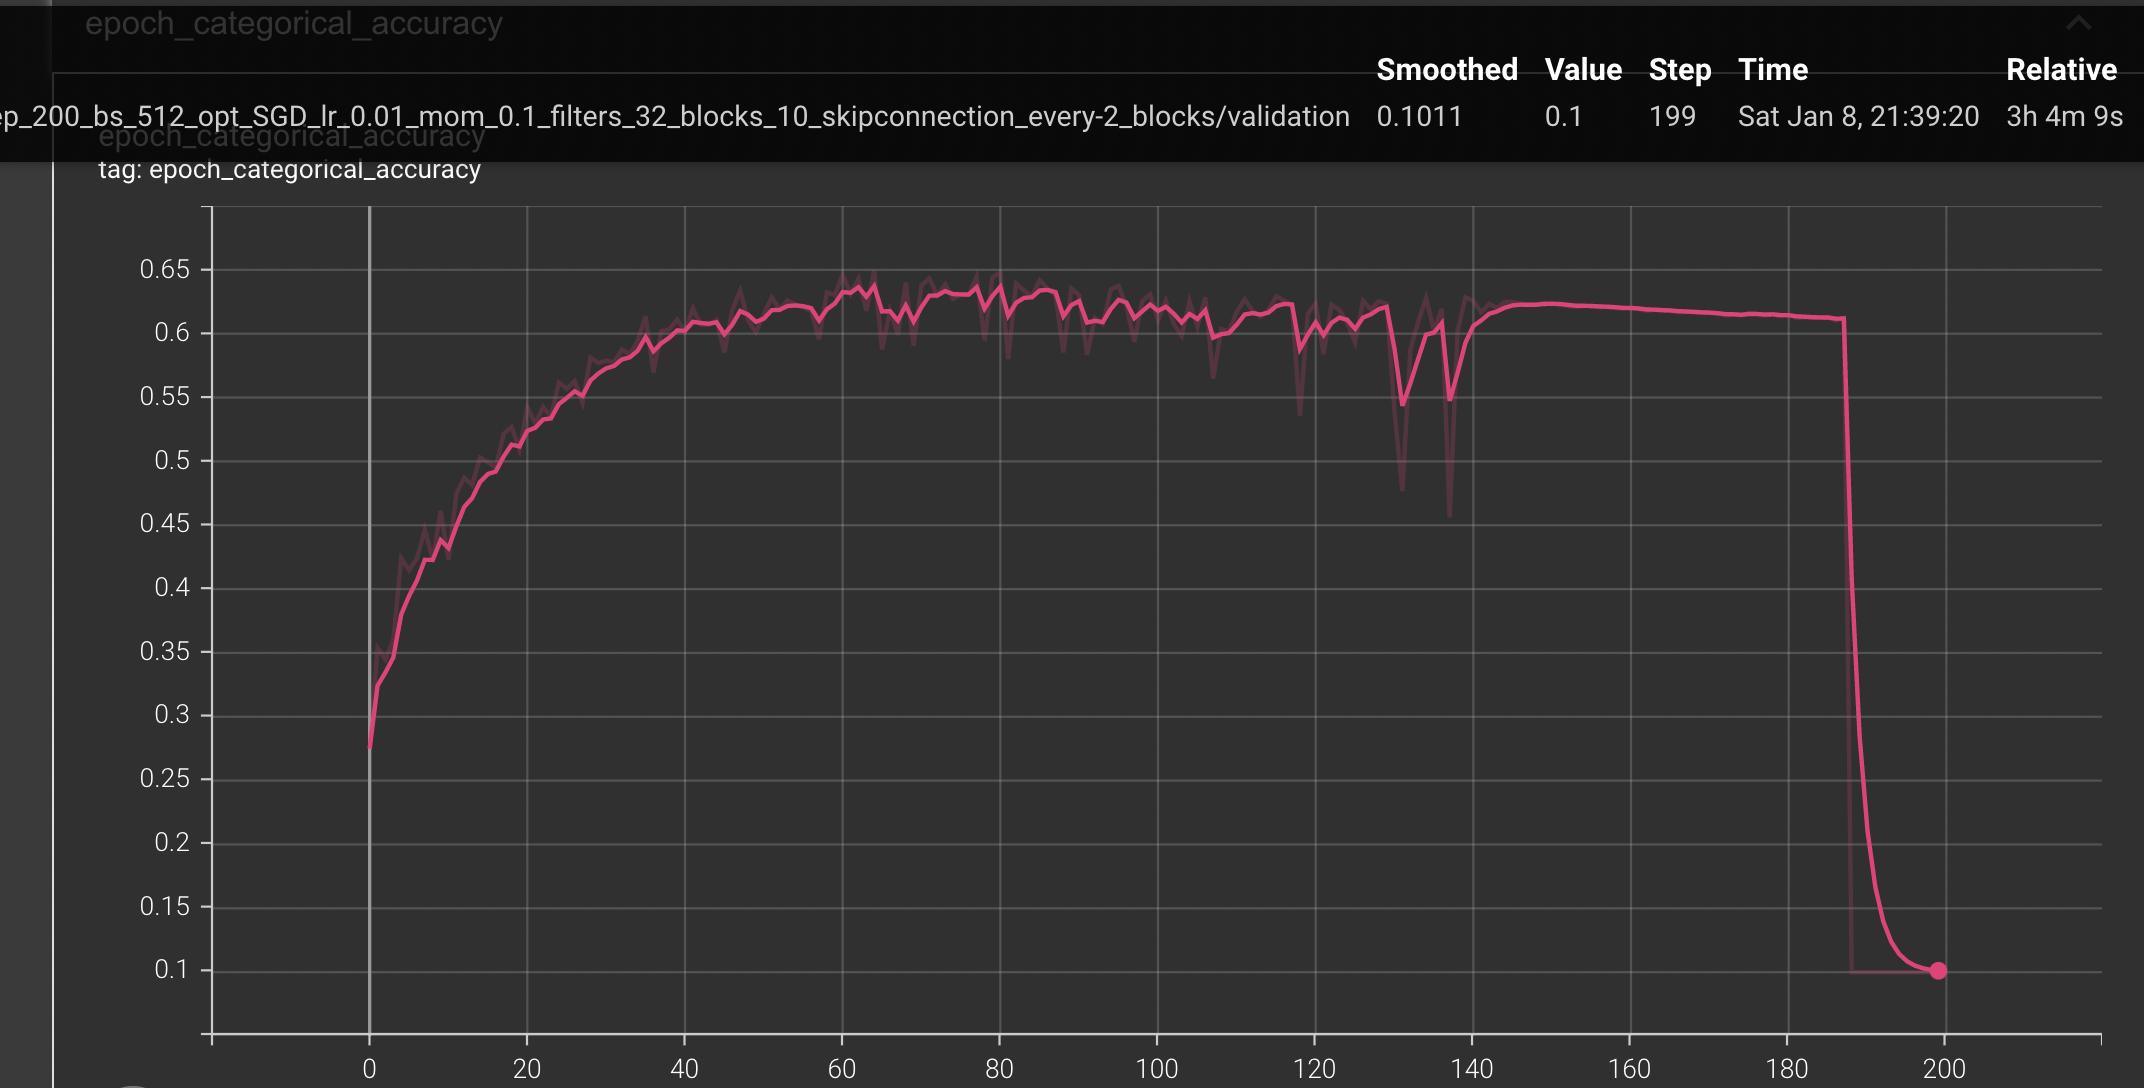

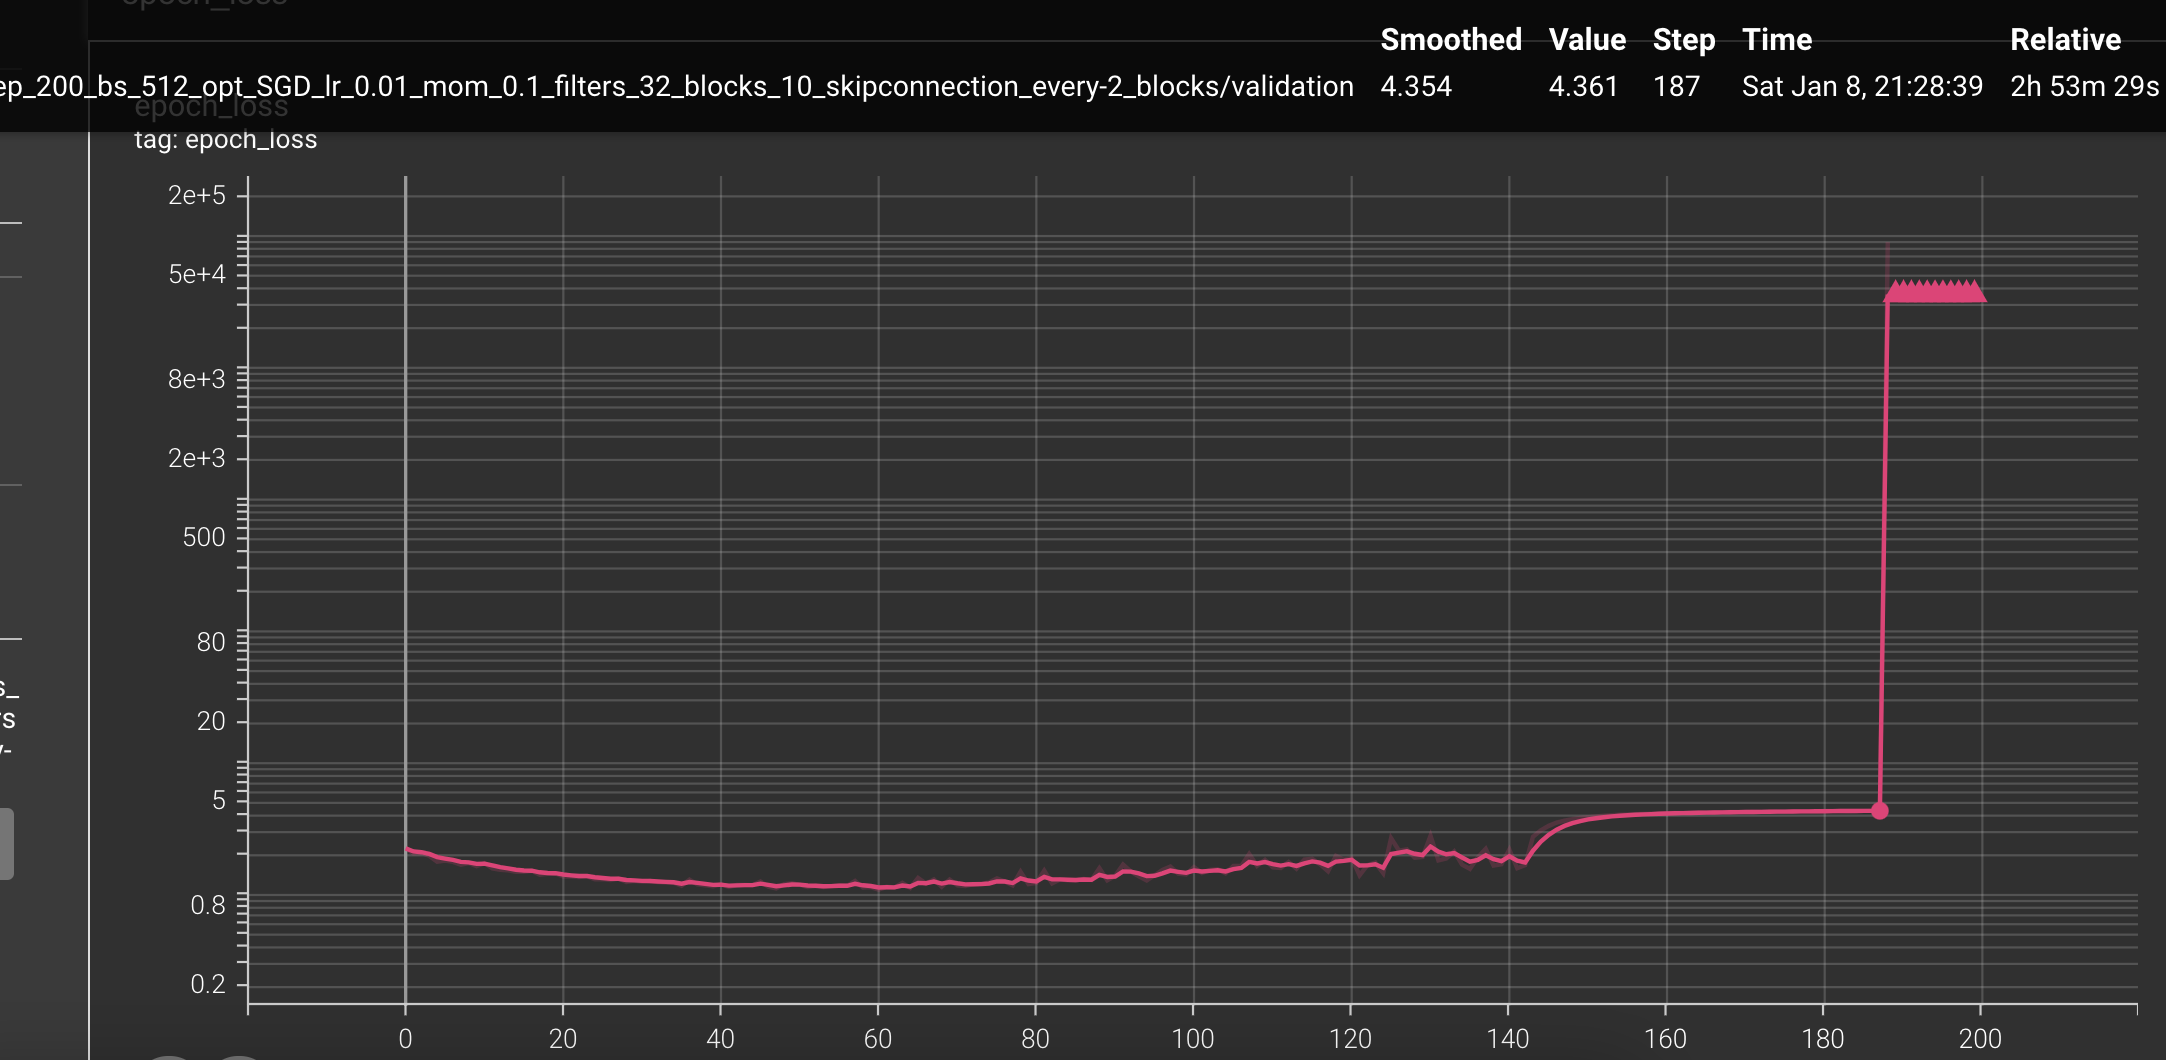

On peut voir qu'au début du training on a une croissance constante mais qu'a la fin il y a une chute.

### Dropout 

In [10]:
def ResNet_dropout(num_layer, filters):
    input_layer = Input(shape=(32, 32, 3))
    hidden_layers = input_layer
    
    for n in range(num_layer):
        prev_layer = hidden_layers
        hidden_layers = Conv2D(filters, (3, 3), padding='same', activation=relu,
                                            kernel_initializer=he_normal)(hidden_layers)
        hidden_layers = Conv2D(filters, (3, 3), padding='same', activation=relu,
                                            kernel_initializer=he_normal)(hidden_layers)
        
        hidden_layers = Dropout(0.2)(hidden_layers)
        if n > 0:
            hidden_layers = keras.layers.Add()([hidden_layers, prev_layer]) / 2.0
        else:
            hidden_layers = keras.layers.Add()([hidden_layers, Dense(32)(prev_layer)]) / 2.0
    
    hidden_layers = Flatten()(hidden_layers)   
    output_layer = Dense(NUM_CLASSES, activation=softmax,
                        kernel_regularizer=l2(0.01),
                        bias_regularizer=l2(0.01))(hidden_layers)
    return Model(input_layer, output_layer)

In [11]:
num_blocks = [5]
for b in num_blocks:
    resnet= ResNet(b,FILTERS)
    resnet.compile(loss=categorical_crossentropy,
                  optimizer=SGD(LEARNING_RATE,MOMENTUM),
                  metrics= categorical_accuracy)
    RESNET_LOG = os.path.join(LOG_DIR, "resnet_dropout",
                        f"resnet_ep_{EPOCHS}_bs_{BATCH_SIZE}_opt_SGD_lr_{LEARNING_RATE}_mom_{MOMENTUM}_filters_{FILTERS}_blocks_{b*2}_skipconnection_every-2_blocks")
    resnet.fit(x_train,y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(x_test, y_test),
              shuffle=SHUFFLE,
              callbacks=[tf.keras.callbacks.TensorBoard(RESNET_LOG, histogram_freq=1)]
              )

2022-01-09 01:10:37.249965: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-09 01:10:37.250014: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/homebrew/Caskroom/miniforge/base/envs/tf26py39/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
2022-01-09 01:10:37.740323: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/200


2022-01-09 01:10:38.012615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 2.3854 - categorical_accuracy: 0.1970

2022-01-09 01:11:22.665115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - 49s 491ms/step - loss: 2.3854 - categorical_accuracy: 0.1970 - val_loss: 2.2589 - val_categorical_accuracy: 0.2750
Epoch 2/200
98/98 [==============================] - 48s 487ms/step - loss: 2.2294 - categorical_accuracy: 0.2812 - val_loss: 2.0682 - val_categorical_accuracy: 0.3539
Epoch 3/200
98/98 [==============================] - 47s 484ms/step - loss: 2.0966 - categorical_accuracy: 0.3279 - val_loss: 2.0839 - val_categorical_accuracy: 0.3448
Epoch 4/200
98/98 [==============================] - 47s 485ms/step - loss: 1.9765 - categorical_accuracy: 0.3642 - val_loss: 1.9799 - val_categorical_accuracy: 0.3602
Epoch 5/200
98/98 [==============================] - 48s 485ms/step - loss: 1.9075 - categorical_accuracy: 0.3854 - val_loss: 1.7885 - val_categorical_accuracy: 0.4240
Epoch 6/200
98/98 [==============================] - 48s 489ms/step - loss: 1.8473 - categorical_accuracy: 0.4040 - val_loss: 1.8208 - val_categorical_accuracy: 0.4147
Epoc

98/98 [==============================] - 59s 600ms/step - loss: 0.6131 - categorical_accuracy: 0.8411 - val_loss: 1.5491 - val_categorical_accuracy: 0.6212
Epoch 98/200
98/98 [==============================] - 59s 601ms/step - loss: 0.5976 - categorical_accuracy: 0.8510 - val_loss: 1.6425 - val_categorical_accuracy: 0.5937
Epoch 99/200
98/98 [==============================] - 59s 607ms/step - loss: 0.5976 - categorical_accuracy: 0.8524 - val_loss: 1.4500 - val_categorical_accuracy: 0.6257
Epoch 100/200
98/98 [==============================] - 58s 595ms/step - loss: 0.5908 - categorical_accuracy: 0.8599 - val_loss: 1.4298 - val_categorical_accuracy: 0.6307
Epoch 101/200
98/98 [==============================] - 57s 584ms/step - loss: 0.5652 - categorical_accuracy: 0.8599 - val_loss: 1.6254 - val_categorical_accuracy: 0.6106
Epoch 102/200
98/98 [==============================] - 57s 580ms/step - loss: 0.5604 - categorical_accuracy: 0.8649 - val_loss: 1.4705 - val_categorical_accuracy: 0.6

98/98 [==============================] - 48s 492ms/step - loss: nan - categorical_accuracy: 0.1000 - val_loss: nan - val_categorical_accuracy: 0.1000
Epoch 194/200
98/98 [==============================] - 48s 492ms/step - loss: nan - categorical_accuracy: 0.1000 - val_loss: nan - val_categorical_accuracy: 0.1000
Epoch 195/200
98/98 [==============================] - 48s 492ms/step - loss: nan - categorical_accuracy: 0.1000 - val_loss: nan - val_categorical_accuracy: 0.1000
Epoch 196/200
98/98 [==============================] - 48s 490ms/step - loss: nan - categorical_accuracy: 0.1000 - val_loss: nan - val_categorical_accuracy: 0.1000
Epoch 197/200
98/98 [==============================] - 48s 490ms/step - loss: nan - categorical_accuracy: 0.1000 - val_loss: nan - val_categorical_accuracy: 0.1000
Epoch 198/200
98/98 [==============================] - 48s 491ms/step - loss: nan - categorical_accuracy: 0.1000 - val_loss: nan - val_categorical_accuracy: 0.1000
Epoch 199/200
98/98 [=========

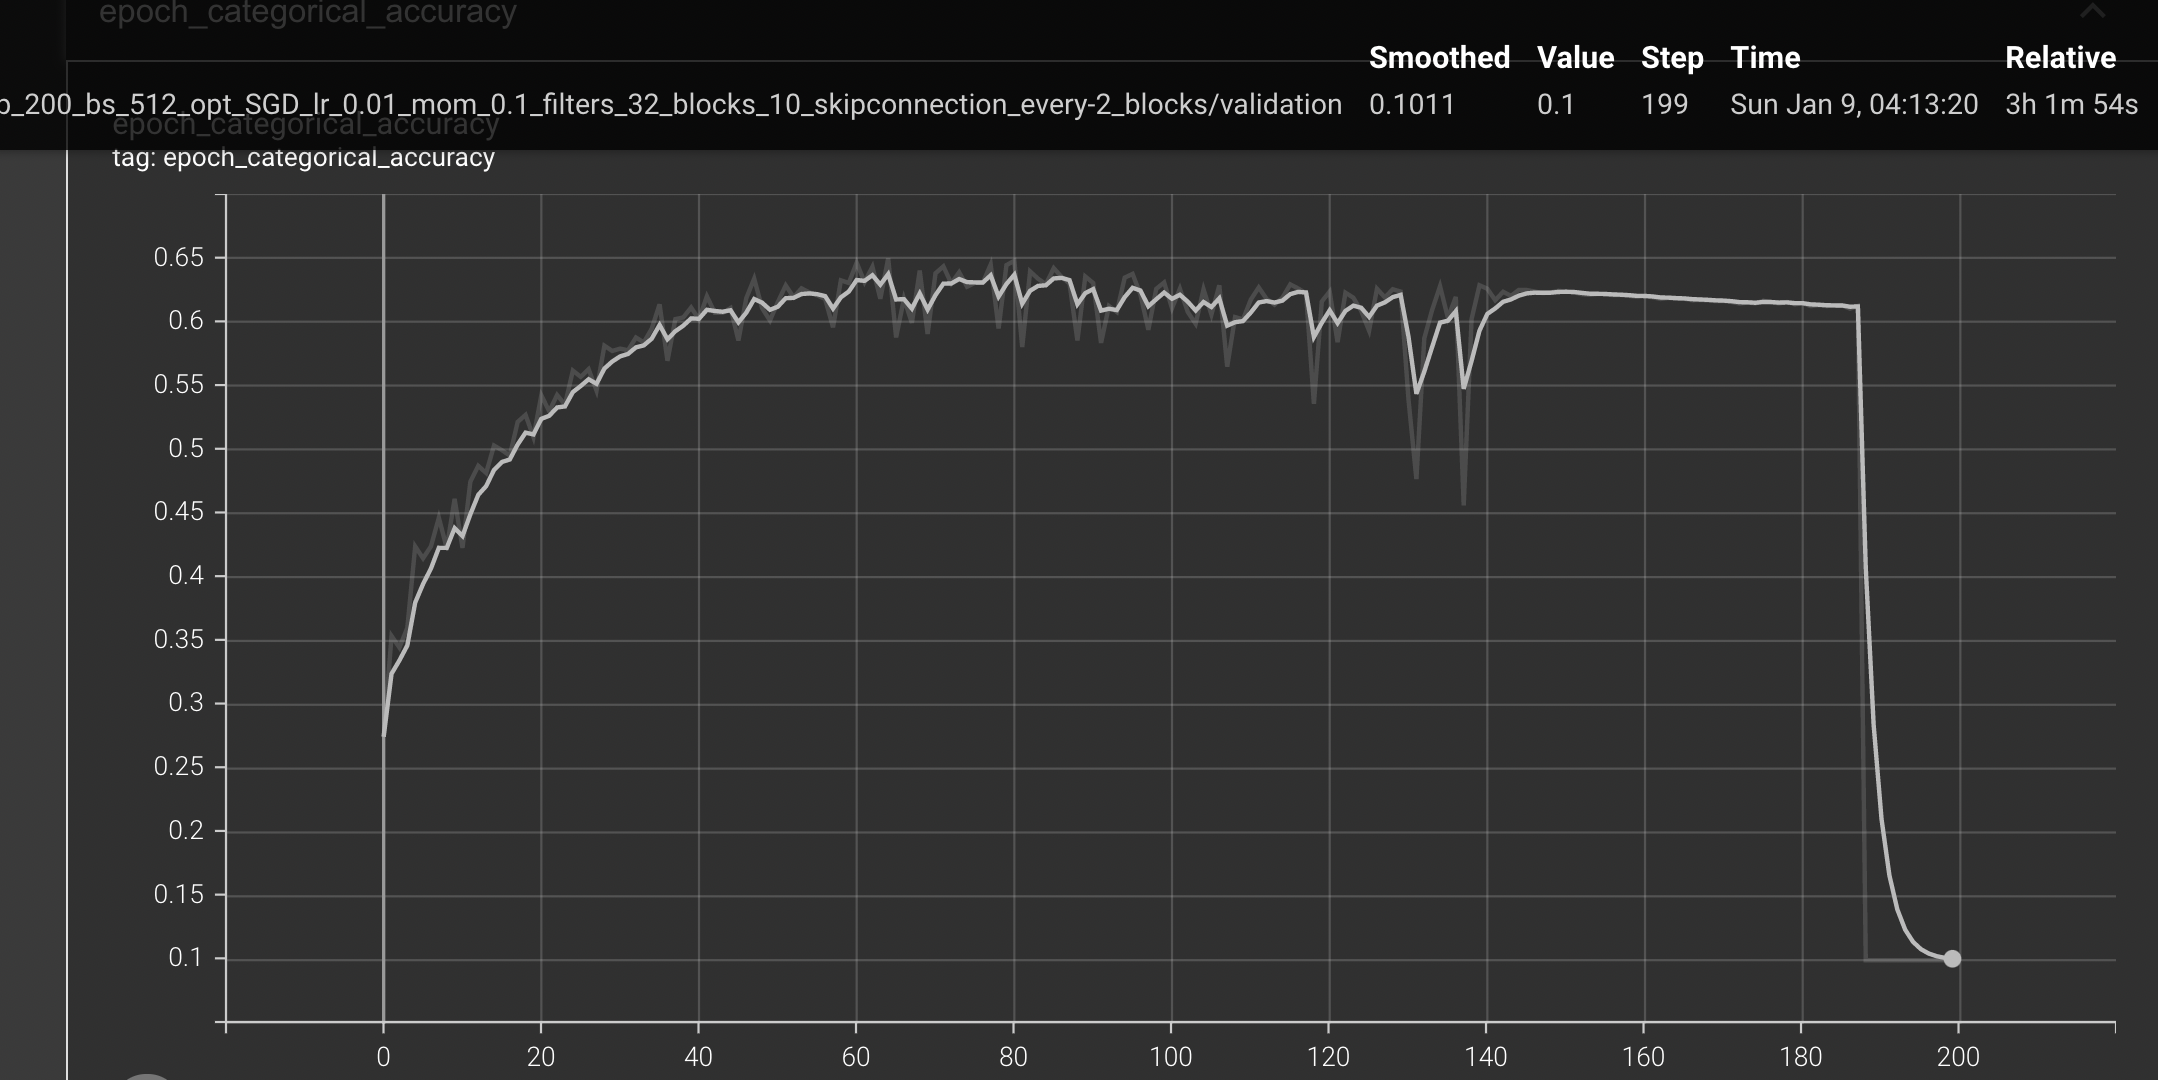

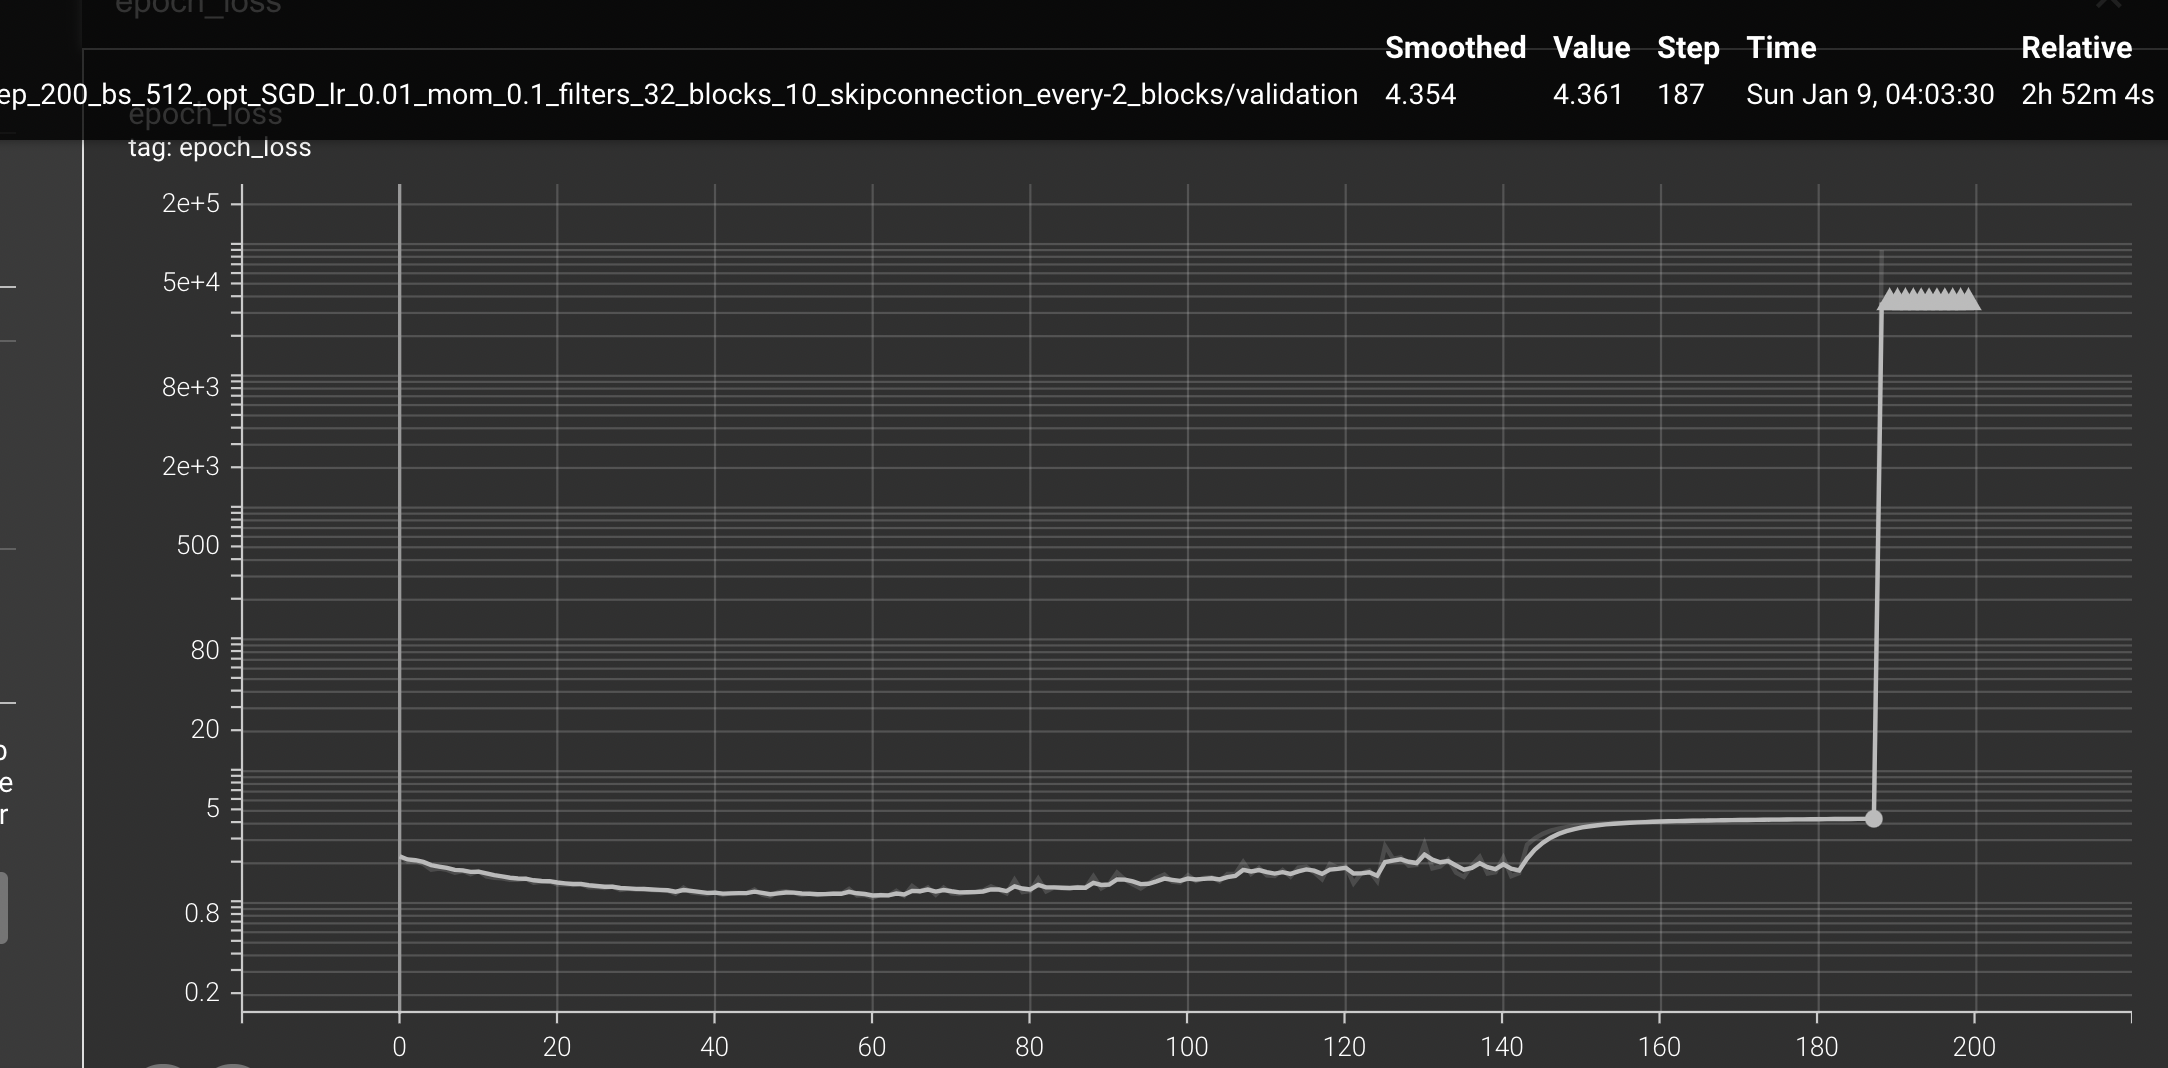

On peut dire que le fait d'avoir desactiver 20 % des neuronnes nous donne des resultats assez similaire que le modele avec des couches dense dans les blocks.

Je n'ai pas eu le temps d'approfondir les analyses de la structure des modeles mais si j'avais continué j'aurais essayé de regler le probleme sur-apprentissage avec data-augmentation.